In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data.csv', delimiter=',', encoding='ISO-8859-1')

In [ ]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [ ]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
data.shape

(541909, 8)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data = data[data['Quantity'] > 0]
data[data['UnitPrice']<0].shape[0]

0

Drop the negative values or quantity

In [ ]:
data.drop(data[data['Quantity'] < 0].index, inplace=True)

<ipython-input-11-2d34c3c0e45d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(data[data['Quantity'] < 0].index, inplace=True)


##**Feature Engineering**
####**Purpose**: Creating new features such as total sales, number of transactions, and last transaction days.

**Expected Output:** Additional features added to the dataset.

Calculating Total Sales or Monetary Value

In [ ]:
data['Sales'] = data['Quantity'] * data['UnitPrice']
new_data = data.groupby('CustomerID')['Sales'].sum().reset_index()
new_data

<ipython-input-12-6d926ee3bcf3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sales'] = data['Quantity'] * data['UnitPrice']


,CustomerID,Sales
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4334,18280.0,180.60
4335,18281.0,80.82
4336,18282.0,178.05
4337,18283.0,2094.88


This code calculates the total sales made by each customer by grouping the dataset by unique customer IDs and summing the sales amounts associated with each customer. After aggregating the sales data, the index of the resulting DataFrame is reset to ensure a consistent structure, with **'CustomerID'** as a regular column and a default integer index assigned. The resulting DataFrame, stored in new_data, contains two columns: **'CustomerID'** and **'Sales'**, with each row representing a unique customer and their corresponding total sales amount.

Calculating Number of Transactions

In [ ]:
num_trans = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()
num_trans

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4334,18280.0,10
4335,18281.0,7
4336,18282.0,12
4337,18283.0,756


Calculating Last Transaction

In [ ]:
#Converting 'InvoiceDate' to DateTime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
#Calculating 'Last Transaction' Days:
data['Last Transaction'] = (data['InvoiceDate'].max() - data['InvoiceDate']).dt.days
#Grouping by 'CustomerID' and 'Country' and Calculating Maximum 'Last Transaction'
lt = data.groupby(['CustomerID', 'Country'])['Last Transaction'].max().reset_index()
#Merging with Number of Transactions
merge_table = pd.merge(lt, num_trans, how='inner', on='CustomerID')
new_df = pd.merge(merge_table, new_data, how='inner', on='CustomerID')
print(lt)
print(new_df)

      CustomerID         Country  Last Transaction
0        12346.0  United Kingdom               325
1        12347.0         Iceland               366
2        12348.0         Finland               357
3        12349.0           Italy                18
4        12350.0          Norway               309
...          ...             ...               ...
4342     18280.0  United Kingdom               277
4343     18281.0  United Kingdom               180
4344     18282.0  United Kingdom               125
4345     18283.0  United Kingdom               336
4346     18287.0  United Kingdom               201

[4347 rows x 3 columns]
      CustomerID         Country  Last Transaction  InvoiceNo     Sales
0        12346.0  United Kingdom               325          1  77183.60
1        12347.0         Iceland               366        182   4310.00
2        12348.0         Finland               357         31   1797.24
3        12349.0           Italy                18         73   1757.55
4  

By performing these steps, we obtain a comprehensive view of each customer's transaction history, including the time elapsed since their last purchase. This information is essential for understanding customer engagement and can be used for targeted marketing strategies and customer retention efforts.

**6. Removing Outliers**

**Purpose:** Identifying and removing outliers from the dataset to improve clustering accuracy.

**Expected Output:** Boxplot visualization before and after outlier removal.

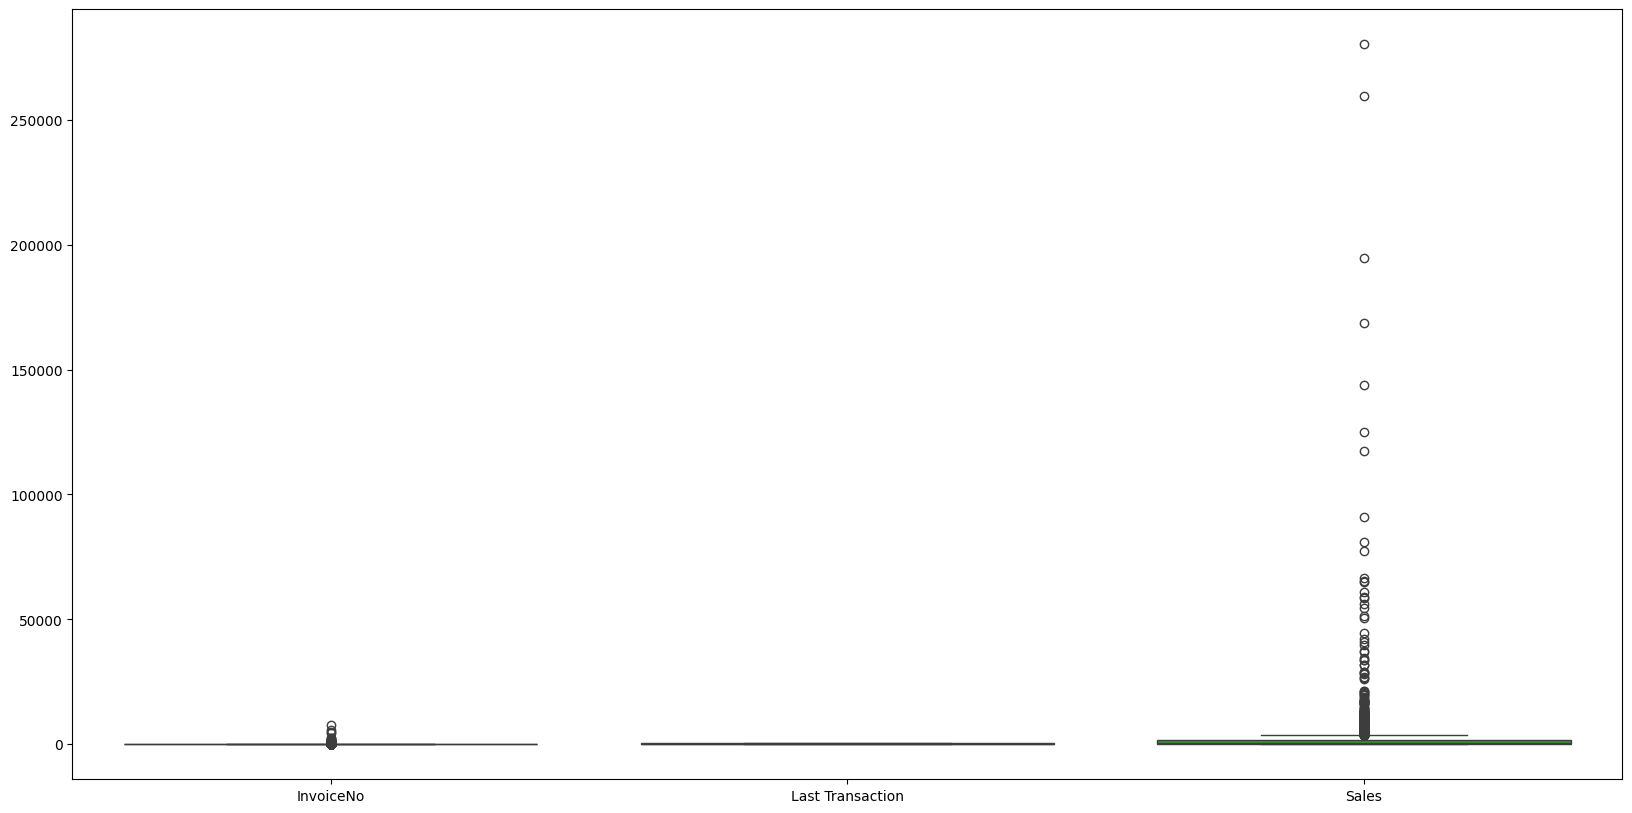

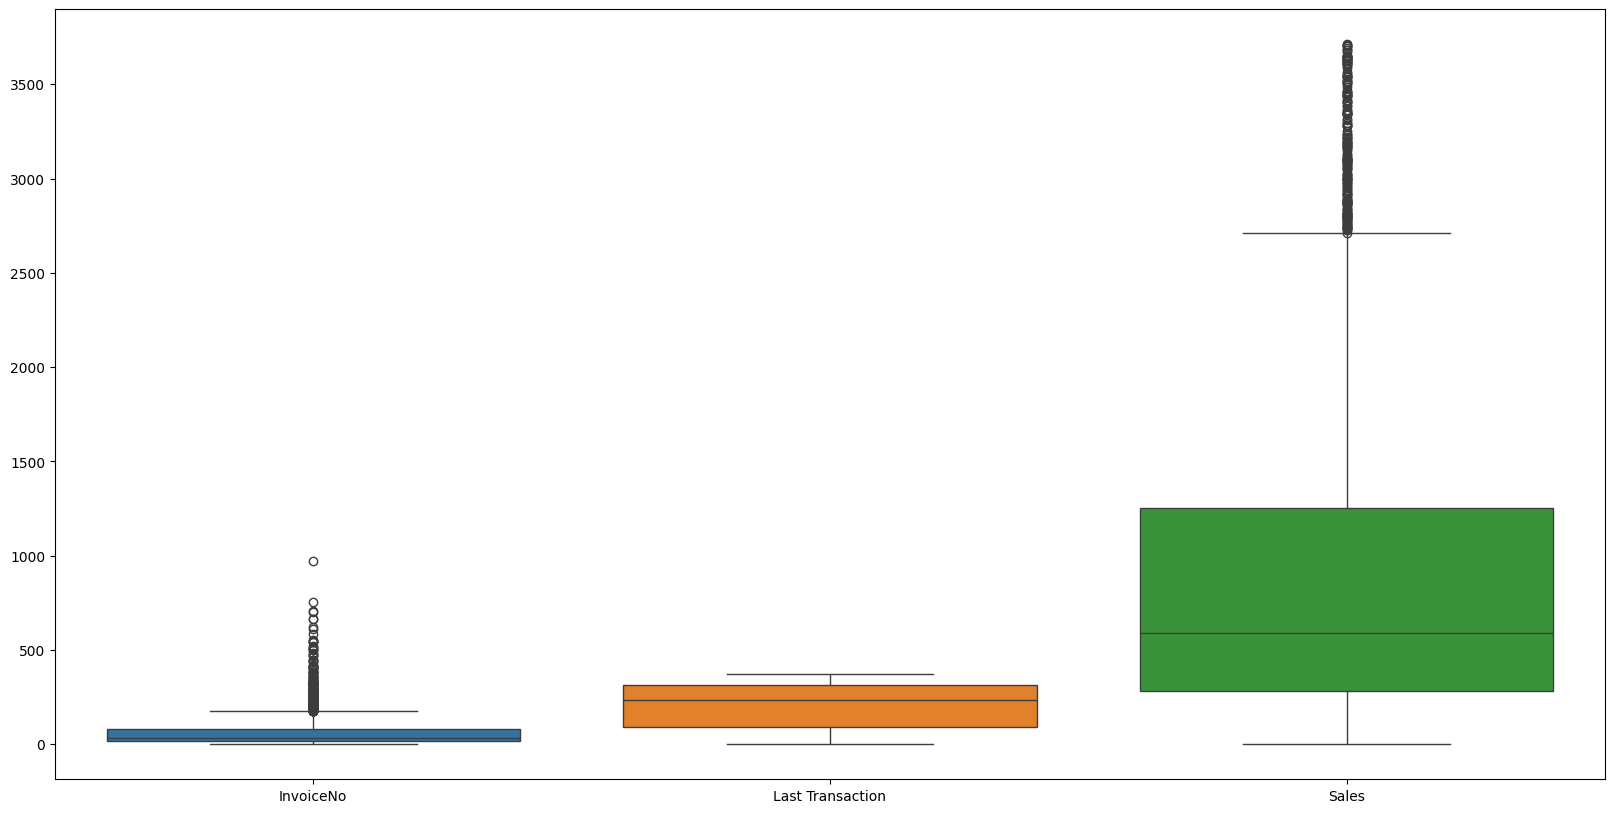

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=new_df[['InvoiceNo', 'Last Transaction', 'Sales']])
plt.show()

IQR = new_df['Sales'].quantile(0.75) - new_df['Sales'].quantile(0.25)
lower_limit = new_df['Sales'].quantile(0.25) - 1.5 * IQR
upper_limit = new_df['Sales'].quantile(0.75) + 1.5 * IQR
new_df_iqr = new_df[(new_df['Sales'] < upper_limit) & (new_df['Sales'] > lower_limit)]

plt.figure(figsize=(20, 10))
sns.boxplot(data=new_df_iqr[['InvoiceNo', 'Last Transaction', 'Sales']])
plt.show()

new_df_iqr.reset_index(drop=True, inplace=True)

###**Visualization of Correlation Matrix using Heatmap**
In this step, we'll visualize the correlation between different features of our dataset using a heatmap. This visualization technique helps us understand the relationships between variables and identify any patterns or dependencies.

###**1. Normalization of Given Dataset using MinMaxScaler:**
We select relevant columns ('Last Transaction', 'InvoiceNo', 'Sales') from the dataset for normalization.

The MinMaxScaler is applied to scale the selected features between 0 and 1.

The scaled data is converted back to a DataFrame and assigned column names.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
new2_df= new_df_iqr[['Last Transaction','InvoiceNo','Sales']]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(new2_df)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = ['Last Transaction','InvoiceNo','Sales']
scaled_df['Country'] = new_df_iqr['Country']
scaled_df

,Last Transaction,InvoiceNo,Sales,Country
0,0.957105,0.030960,0.484200,Finland
1,0.048257,0.074303,0.473507,Italy
2,0.828418,0.016512,0.090092,Norway
3,0.793566,0.086687,0.675160,Norway
4,0.544236,0.003096,0.023978,Bahrain
...,...,...,...,...
3918,0.742627,0.009288,0.048656,United Kingdom
3919,0.482574,0.006192,0.021774,United Kingdom
3920,0.335121,0.011352,0.047969,United Kingdom
3921,0.900804,0.779154,0.564388,United Kingdom


**2. K-Means Clustering - Plotting the Graph using Elbow Method:**
We prepare the dataset for clustering by dropping the 'Country' column.

The Elbow Method is employed to determine the optimal number of clusters for K-Means.

The Yellowbrick library's KElbowVisualizer is utilized to visualize the elbow plot.

K-Means clustering is performed with the chosen number of clusters, and cluster assignments are added to the DataFrame.

The centroids of the clusters are computed and displayed.

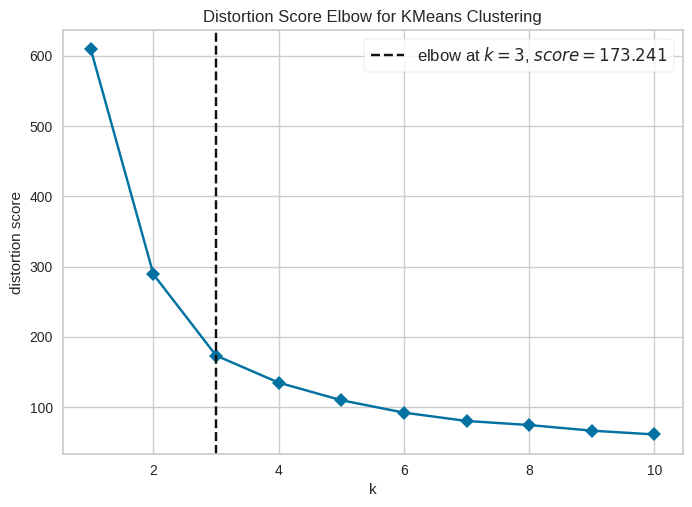

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
df_k=scaled_df.drop(columns=['Country'],axis=1)
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_k)        # Fit data to visualizer
visualizer.show()

In [ ]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df_k)
df_k['clusters'] = y_predicted
df_k

,Last Transaction,InvoiceNo,Sales,clusters
0,0.957105,0.030960,0.484200,2
1,0.048257,0.074303,0.473507,1
2,0.828418,0.016512,0.090092,0
3,0.793566,0.086687,0.675160,2
4,0.544236,0.003096,0.023978,0
...,...,...,...,...
3918,0.742627,0.009288,0.048656,0
3919,0.482574,0.006192,0.021774,1
3920,0.335121,0.011352,0.047969,1
3921,0.900804,0.779154,0.564388,2


In [ ]:
km.cluster_centers_

array([[0.77670358, 0.04300671, 0.15800362],
       [0.2209531 , 0.04001379, 0.14854249],
       [0.79834825, 0.15821687, 0.63465266]])

**3. Model Evaluation:**
Silhouette score is calculated to evaluate the performance of the K-Means clustering model.

The silhouette score measures the compactness of clusters and ranges from -1 to 1, with higher scores indicating better clustering.

Hierarchical clustering using AgglomerativeClustering is performed with 3 clusters, and cluster assignments are added to the DataFrame.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = silhouette_score(df_k, km.labels_, metric='euclidean')
print(score)

from sklearn.cluster import AgglomerativeClustering
hierarchial = AgglomerativeClustering(n_clusters=3)
y_predicted_hierarchial = hierarchial.fit_predict(df_k)
df_k['clusters_hierarchial']= y_predicted_hierarchial
df_k.head(30)

0.782476290172844


,Last Transaction,InvoiceNo,Sales,clusters,clusters_hierarchial
0,0.957105,0.030960,0.484200,2,2
1,0.048257,0.074303,0.473507,1,1
2,0.828418,0.016512,0.090092,0,0
3,0.793566,0.086687,0.675160,2,2
4,0.544236,0.003096,0.023978,0,0
5,0.619303,0.058824,0.290805,0,0
6,0.571046,0.012384,0.123768,0,0
7,0.871314,0.059856,0.757436,2,2
8,0.402145,0.018576,0.314691,1,1
9,0.536193,0.132095,0.717194,2,2


In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.2,min_samples = 4 )
y_predicted_dbscan = dbscan.fit_predict(df_k)
df_k['clusters_dbscan'] = y_predicted_dbscan
df_k

,Last Transaction,InvoiceNo,Sales,clusters,clusters_hierarchial,clusters_dbscan
0,0.957105,0.030960,0.484200,2,2,0
1,0.048257,0.074303,0.473507,1,1,1
2,0.828418,0.016512,0.090092,0,0,2
3,0.793566,0.086687,0.675160,2,2,0
4,0.544236,0.003096,0.023978,0,0,2
...,...,...,...,...,...,...
3918,0.742627,0.009288,0.048656,0,0,2
3919,0.482574,0.006192,0.021774,1,1,1
3920,0.335121,0.011352,0.047969,1,1,1
3921,0.900804,0.779154,0.564388,2,2,0


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = silhouette_score(df_k, dbscan.labels_, metric='euclidean')
print(score)

0.847996057906089
